In [20]:
#%pip install yfinance pandas numpy scipy python-dateutil

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress

In [16]:
def get_stock_data(ticker, start_date, end_date):
    stock = yf.Ticker(ticker)
    df = stock.history(start=start_date, end=end_date)
    return df['Close']

def calculate_returns(prices):
    returns = prices.pct_change().dropna()
    return returns

def calculate_alpha_beta(stock_returns, market_returns):
    slope, intercept, r_value, p_value, std_err = linregress(market_returns, stock_returns)
    return intercept, slope

def get_risk_free_rate(start_date, end_date, stock_ticker):
    if stock_ticker.endswith(".L"):
        rf_ticker = "^IRX"  # UK 3-Month Treasury Bill
    else:
        rf_ticker = "^TNX"  # US 10-Year Treasury Note

    rf = yf.Ticker(rf_ticker)
    rf_data = rf.history(start=start_date, end=end_date)
    
    if rf_ticker == "^IRX":
        # IRX is in percentage terms, so divide by 100, then annualize by dividing by 12 (monthly rate)
        rf_data['Daily Rate'] = rf_data['Close'] / 100 / 252
    else:
        # TNX is in percentage terms, so divide by 100, then annualize by dividing by 252 (daily rate)
        rf_data['Daily Rate'] = rf_data['Close'] / 100 / 252
    
    return rf_data['Daily Rate']

def get_market_index(stock_ticker):
    if stock_ticker.endswith(".L"):
        return "^FTSE"
    else:
        return "^GSPC"

In [17]:
# User input
ticker = input("Enter the stock ticker symbol: ")
market_index = '^GSPC'  # S&P 500 index
end_date = input("Enter the end date (YYYYMMDD): ")
years = int(input("Enter the number of years: "))

Enter the stock ticker symbol: AZN.L
Enter the end date (YYYYMMDD): 20240725
Enter the number of years: 2


In [19]:
try:
    end = datetime.strptime(end_date, "%Y%m%d")
    start = end - relativedelta(years=years)
except ValueError:
    print("Invalid date format. Please use YYYYMMDD.")
else:
    start_date_yf = start.strftime("%Y-%m-%d")
    end_date_yf = end.strftime("%Y-%m-%d")

    # Fetch stock data
    stock_prices = get_stock_data(ticker, start_date_yf, end_date_yf)
    
    # Determine and fetch market index data
    market_index = get_market_index(ticker)
    market_prices = get_stock_data(market_index, start_date_yf, end_date_yf)
    
    # Fetch risk-free rate data
    rf_data = get_risk_free_rate(start_date_yf, end_date_yf, ticker)

    # Calculate returns
    stock_returns = calculate_returns(stock_prices)
    market_returns = calculate_returns(market_prices)

    # Remove time component from index
    stock_returns.index = stock_returns.index.date
    market_returns.index = market_returns.index.date
    rf_data.index = rf_data.index.date

    # Create a DataFrame to hold all the data with a common date index
    combined_data = pd.DataFrame(index=stock_returns.index)
    combined_data['Stock Returns'] = stock_returns
    combined_data['Market Returns'] = market_returns
    combined_data['Risk-Free Rate'] = rf_data.reindex(combined_data.index)

    # Print combined data to debug alignment
    print("\nCombined Data (with aligned dates):")
    print(combined_data.head())

    # Drop rows with any NaN values
    combined_data = combined_data.dropna()

    if combined_data.empty:
        print("No overlapping data between stock returns, market returns, and risk-free rate.")
    else:
        # Adjust returns by the risk-free rate
        excess_stock_returns = combined_data['Stock Returns'] - combined_data['Risk-Free Rate']
        excess_market_returns = combined_data['Market Returns'] - combined_data['Risk-Free Rate']

        # Calculate alpha and beta
        alpha, beta = calculate_alpha_beta(excess_stock_returns, excess_market_returns)
        
        print(f"\nThe CAPM regression equation for {ticker} is:")
        print(f"Excess Stock Return (ri - rf) = {alpha:.4f} + {beta:.4f} * Excess Market Return (rm - rf)")


Combined Data (with aligned dates):
            Stock Returns  Market Returns  Risk-Free Rate
2022-07-26       0.019426        0.000000        0.000098
2022-07-27      -0.005263        0.005735        0.000095
2022-07-28      -0.008393       -0.000395        0.000092
2022-07-29      -0.002392        0.010633        0.000091
2022-08-01      -0.012542       -0.001347        0.000090
The CAPM regression equation for AZN.L is:
Excess Stock Return (ri - rf) = 0.000097 + 0.884468 * Excess Market Return (rm - rf)


In [15]:
import numpy as np

def calculate_annual_metrics(daily_returns):
    average_annual_return = np.mean(daily_returns) * 252
    annual_variance = np.var(daily_returns) * 252
    return average_annual_return, annual_variance

# Calculate annual metrics for the stock
stock_annual_return, stock_annual_variance = calculate_annual_metrics(stock_returns)

# Calculate annual metrics for the market index
market_annual_return, market_annual_variance = calculate_annual_metrics(market_returns)

# Print the results
print(f"\nAverage Annual Return for {ticker}: {stock_annual_return:.2%}")
print(f"Annual Variance for {ticker}: {stock_annual_variance:.2%}")

print(f"\nAverage Annual Return for {market_index}: {market_annual_return:.2%}")
print(f"Annual Variance for {market_index}: {market_annual_variance:.2%}")



Average Annual Return for AZN.L: 10.62%
Annual Variance for AZN.L: 4.66%

Average Annual Return for ^FTSE: 6.09%
Annual Variance for ^FTSE: 1.21%


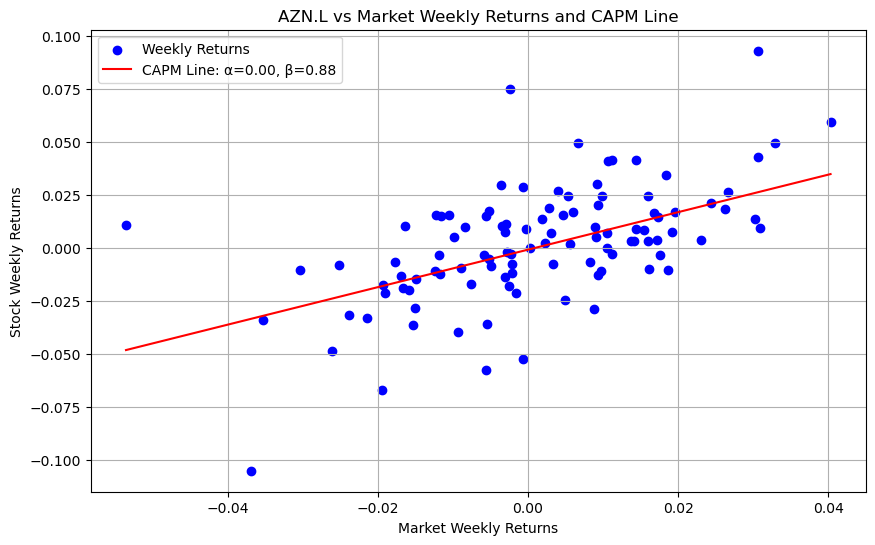

In [23]:
average_rf_daily = rf_data.mean()  # Average daily risk-free rate

# Convert to weekly by multiplying by 5 (assuming 5 trading days in a week)
average_rf_weekly = average_rf_daily * 5

# Calculate weekly returns for plotting
stock_weekly_returns = stock_returns.resample('W').sum()  # Sum returns for the week
market_weekly_returns = market_returns.resample('W').sum()  # Sum returns for the week

# Drop NaN values
stock_weekly_returns = stock_weekly_returns.dropna()
market_weekly_returns = market_weekly_returns.dropna()

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(market_weekly_returns, stock_weekly_returns, label='Weekly Returns', color='blue')

# Calculate the CAPM line
x = np.linspace(market_weekly_returns.min(), market_weekly_returns.max(), 100)
y = alpha + beta * (x - average_rf_weekly)  # Use the average weekly risk-free rate

# Plot the CAPM line
plt.plot(x, y, color='red', label=f'CAPM Line: α={alpha:.2f}, β={beta:.2f}')

# Chart details
plt.xlabel('Market Weekly Returns')
plt.ylabel('Stock Weekly Returns')
plt.title(f'{ticker} vs Market Weekly Returns and CAPM Line')
plt.legend()
plt.grid(True)
plt.show()